In this demo, I will show you how to use DATC RDF.

# Installing DATC RDF

We clone the DATC RDF GitHub repository, which has flow collateral data:

* Link: https://github.com/ieee-ceda-datc/datc-rdf

```bash
git clone https://github.com/ieee-ceda-datc/datc-rdf
cd datc-rdf
git submodule update --init
```

DATC RDF is provided as a docker image.
It is already available at Docker Hub: 

* Link: https://hub.docker.com/r/jinwookjung/rdf

We can launch a container from the image as follows.

```bash
FLOW=/submodules/OpenROAD-flow-scripts/flow
docker run --rm -it \
  -v $(pwd)/$FLOW:/openroad-flow \
  -v $(pwd)/workspace:/root/workspace \
  jinwookjung/rdf
```

In Docker container, check the installation:

```bash
which sbt assure yosys fault openroad
```




# RTL Generation with Chisel

We use `riscv-mini` core for this demo: 

* It is a simple RISC-V 3-stage pipeline written in Chisel.
* Link: https://github.com/ucb-bar/riscv-mini.git

To generate the RTL of `riscv-mini`, run the following command.
    
```bash
cd workspace
git clone https://github.com/ucb-bar/riscv-mini.git
(cd riscv-mini && make)
```

Once completed, the generated RTL is located at `./riscv-mini/generated-src`.

# RTL Obfuscation with ASSURE

We first generate secret key for obfuscation.

```bash
mkdir assure
generate_key -b 512 -o assure/key_512bit.txt
```

Then, we run ASSURE to get the obfuscated design:

```bash
assure \
    --top Core \
    -D SYNTHESIS \
    --input-key=./assure/key_512bit.txt \
    --enable-key-reuse \
    --obfuscate-ops \
    --obfuscate-branch \
    --output=./assure/out \
    ./riscv-mini/generated-src/Tile.v
```

Once completed, the obfusctaed RTLs are located at `./assure/out/hdl`.
They have suffix of `*_obf.v`.

# Logic Synthesis with Yosys+ABC

We use OpenROAD flow Makefile.

First, we create flow workspace, and copy OpenROAD flow Makefile there.

```bash
mkdir spnr-flow && cd spnr-flow
cp /openroad-flow/Makefile .
```

Then, we create SDC file, which has clock period constraints.

```bash
cat <<EOT >> constraint.sdc
create_clock [get_ports clock] -period 20
EOT
```

Now, we create design config, input for the OpenROAD flow Makefile.

```bash
cat <<EOT >> config.mk
export DESIGN_NICKNAME   = riscv-mini
export DESIGN_NAME       = Core_0_obf
export PLATFORM          = sky130hd

export VERILOG_FILES     = \$(sort \$(wildcard ../assure/out/hdl/*.v))
export SDC_FILE          = ./constraint.sdc

export CORE_UTILIZATION  = 20
export CORE_ASPECT_RATIO = 1
export CORE_MARGIN       = 2
export PLACE_DENSITY     = 0.6

export PLATFORM_HOME     = /openroad-flow/platforms
export UTILS_DIR         = /openroad-flow/util
export SCRIPTS_DIR       = /openroad-flow/scripts
EOT
```

Now, run synthesis step of the flow.

```bash
make synth DESIGN_CONFIG=./config.mk
```

Once completed, gate-level netlist is available at:

```bash
./results/sky130hd/riscv-mini/base/1_synth.v
```

# DFT Insertion with Fault

We use Fault.

```bash
mkdir dft

# Fault needs DFF cell name to create scan chain.
LIB=/openroad-flow/platforms/sky130hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib 
DFF=sky130_fd_sc_hd__dfrtp_1,sky130_fd_sc_hd__dfxtp_1

fault chain \
    --clock clock --reset reset \
    --liberty $LIB \
    --dff $DFF \
    --output dft/fault.v \
    ./results/sky130hd/riscv-mini/base/1_synth.v
```

Once completed, the DFT-inserted netlist is available at `./dft/fault.v`.

We use as this netlist as the gate-level netlist for P&R.

```bash
mv results/sky130hd/riscv-mini/base/1_synth.v \
   results/sky130hd/riscv-mini/base/1_synth.no_dft.v
   
ln -s $(readlink -f dft/fault.v) \
      ./results/sky130hd/riscv-mini/base/1_synth.v
```

# P&R with OpenROAD

We run P&R using OpenROAD.
We already have the OpenROAD flow Makefile in our workspace, so we can use the following command.

```bash
make DESIGN_CONFIG=./config.mk
```

# Checking Results

Once completed, close the container:

```bash
exit
```

And check the results:

```bash
cd workspace
ls spnr-flow/logs/sky130hd/riscv-mini/base
ls spnr-flow/results/sky130hd/riscv-mini/base
ls spnr-flow/reports/sky130hd/riscv-mini/base
```

The OpenROAD flow also saves layout images in the `reports` directory:

* `final.webp`: Final layout
* `final_placement.webp`: Placement
* `final_clocks.webp`: Clock tree
* `final_resizer.webp`: Resized instances.

which we can plot.

Text(0.5, 1.0, 'Resizer output')

<Figure size 432x288 with 0 Axes>

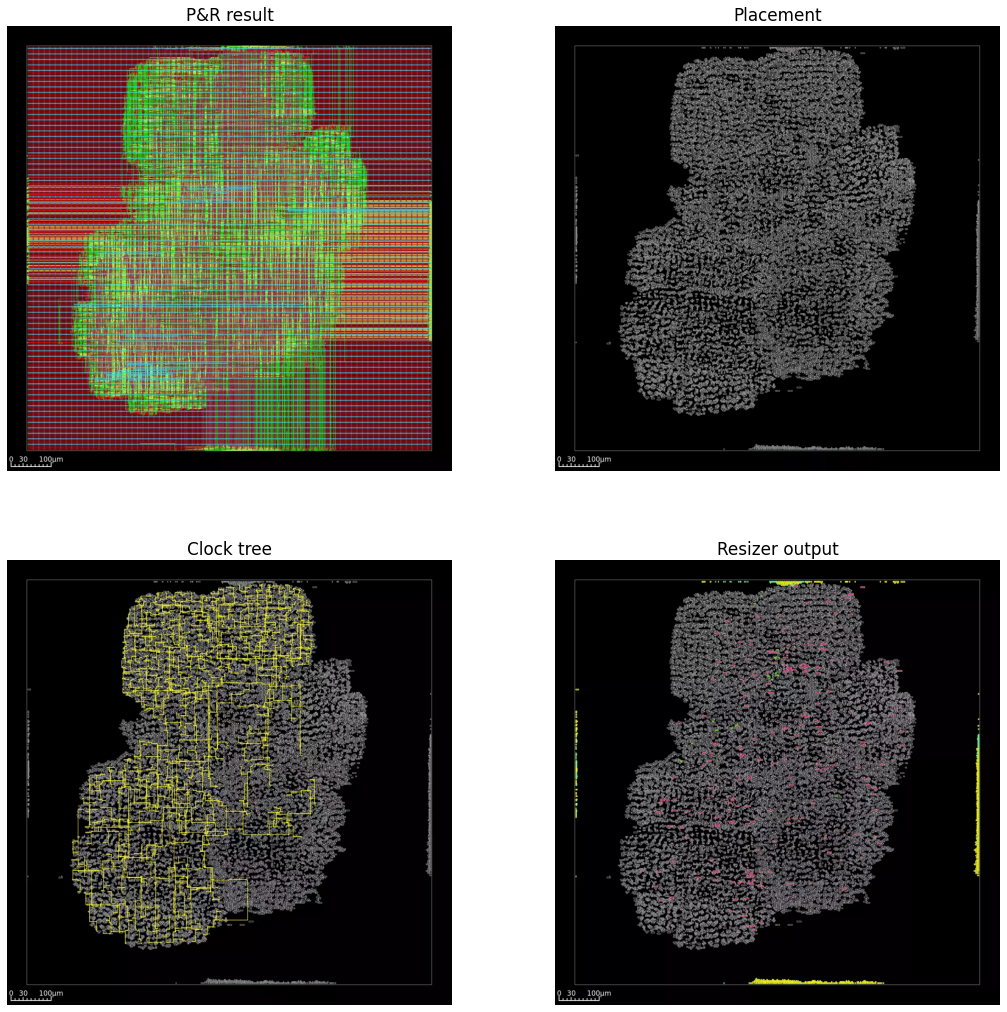

In [1]:
import webp
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plt.tight_layout()

fig, axs = plt.subplots(2,2)
fig.set_size_inches(18,18)
[axi.set_axis_off() for axi in axs.ravel()]

workspace = "datc-rdf/workspace/spnr-flow"
report_dir = "{}/reports/sky130hd/riscv-mini/base".format(workspace)
pnr = webp.load_image("{}/final.webp".format(report_dir))
place = webp.load_image("{}/final_placement.webp".format(report_dir))
clock = webp.load_image("{}/final_clocks.webp".format(report_dir))
resize = webp.load_image("{}/final_resizer.webp".format(report_dir))

axs[0][0].imshow(pnr)
axs[0][1].imshow(place)
axs[1][0].imshow(clock)
axs[1][1].imshow(resize)

axs[0][0].set_title("P&R result")
axs[0][1].set_title("Placement")
axs[1][0].set_title("Clock tree")
axs[1][1].set_title("Resizer output")